# Recognition of Affective State Through Facial Expressions 
## Members
- DICHOSO, Aaron Gabrielle C.
- NATIVIDAD, Josh Austin Mikhail T.
- RAZON, Luis Miguel Antonio B.

# AffectNet
**Dataset Description** (from [link](https://paperswithcode.com/dataset/affectnet))\
AffectNet is a large facial expression dataset with around 0.4 million images manually labeled for the presence of eight (neutral, happy, angry, sad, fear, surprise, disgust, contempt) facial expressions along with the intensity of valence and arousal.

This dataset retrieved was already pre-processed by [Noam Segal](https://www.kaggle.com/noamsegal) for the purpose of machine learning. All images were reduced to 96 x 96 pixels, and cropped to the face. Some monochromatic images were removed through the use of Principal Component Analysis.

**Notebook Description**\
This notebook utilizes the AffectNet Dataset to create a model focused on the recognition of four emotions (happy, sad, angry, and neutral) based on the given facial expression features extracted by the OpenCV library.

# Libraries
These libraries were used in the development of this notebook.

In [ ]:
# If you are accessing this notebook for the first time without the necessary libraries, run this code block to download them.

!pip install opencv-python
!pip install --upgrade pip
!pip install mtcnn
!pip install mediapipe==0.10.9
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

In [1]:
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
import statistics
from mtcnn import MTCNN
from PIL import Image
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np







# Data Import and Visualization

The file `labels.csv` contain metadata about the dataset, containing the columns `pth`, `label`, and `relFCs`.

- **pth**: Path of the image file
- **label**: emotion label of the image
- **relFCs**: Principal Component Analysis Percentage

Examples of images that will be used in this notebook can be seen in the code block below.

In [12]:
faces_df = pd.read_csv('./dataset/archive/labels.csv')
faces_df

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108
...,...,...,...,...
28170,28170,surprise/image0034960.jpg,surprise,0.825263
28171,28171,surprise/image0034961.jpg,surprise,0.738646
28172,28172,surprise/image0034966.jpg,surprise,0.774524
28173,28173,surprise/image0034973.jpg,neutral,0.766952


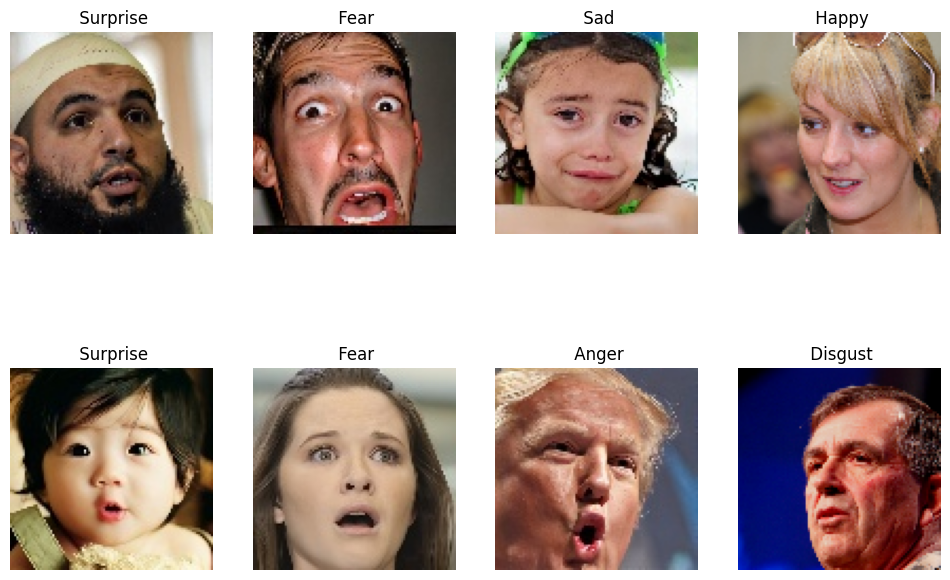

In [13]:
base_path = "./dataset/archive/"
random_images = []
def render_image(img_path, dataframe):
    pth = dataframe.iloc[img_path, 1]
    image_path = base_path + pth
    img = mpimg.imread(image_path)
    return img, dataframe.iloc[img_path, 2].title(), pth  # returns the img + label
# Display 8 random images from the dataset
i = 8
random_images = [(randint(1, faces_df.shape[0])) for x in range(i)]
num_cols = int(i / 2)
num_rows = int(i / num_cols) + i % 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
for i in range(0, i):
    row = i // num_cols
    col = i % num_cols
    img_path, title, pth = render_image(random_images[i], faces_df)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f" {title}")
    axes[row, col].axis("off")

# Data Cleaning

## Removing Unneeded Emotions

Before performing other cleaning operations, the dataframe reference should be reduced to only the four emotions specified, to remove unecessary checking on the other emotions that won't be used in training the model.

In [9]:
#Step 1: Remove other emotions except from Happy, Sad, Anger, Neutral
emotions = ['happy', 'sad', 'anger', 'neutral']
init_size = faces_df.shape[0]

faces_df = faces_df.loc[faces_df['label'].isin(emotions)]

print(f"Before: {init_size}\nAfter: {faces_df.shape[0]}")
faces_df

Before: 28175
After: 13800


,Unnamed: 0,pth,label,relFCs
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
4,4,anger/image0000106.jpg,anger,0.849108
5,5,anger/image0000132.jpg,anger,0.819448
6,6,anger/image0000138.jpg,anger,0.852052
...,...,...,...,...
28141,28141,surprise/image0034852.jpg,neutral,0.695162
28164,28164,surprise/image0034931.jpg,happy,0.872834
28165,28165,surprise/image0034939.jpg,neutral,0.882535
28166,28166,surprise/image0034946.jpg,happy,0.794207


<function matplotlib.pyplot.show(close=None, block=None)>

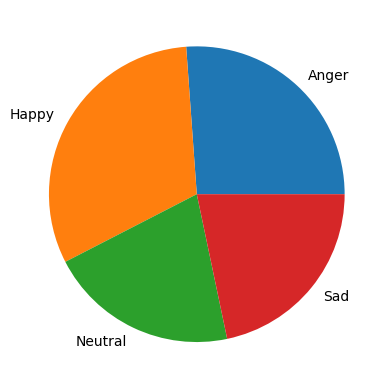

In [10]:
sum_df = faces_df[['pth', 'label']].groupby(['label']).count()
sum_df.rename(columns={'pth':'sum'}, inplace=True)
plt.pie(sum_df['sum'], labels = ['Anger', 'Happy', 'Neutral', 'Sad'])
plt.show

In [23]:
sum_df

,sum
label,
anger,3608
happy,4336
neutral,2861
sad,2995


## Essential Data Cleaning

Once the dataframe has been specified to the needed emotion labels, we can start with the essential data cleaning of removing duplicate and missing values; howver, based on the results, there were none.

In [24]:
#Step 2: Essential Cleaning

#Duplicate Values
init_size = faces_df.shape[0]
faces_df = faces_df.drop_duplicates()
print("Duplicate Values")
print(f"Before: {init_size}\nAfter: {faces_df.shape[0]}")

#Missing Values
faces_df = faces_df.dropna()
print("Missing Values")
print(f"Before: {init_size}\nAfter: {faces_df.shape[0]}")


Duplicate Values
Before: 13800
After: 13800
Missing Values
Before: 13800
After: 13800


## Identifying proper labels from mismatch
It can be seen that many entries are mismatched, where the label of the given image is stored in the wrong folder, which can be observed in the list below.

Upon further inspection, most faces found in the list of conflicts had an impression of an emotion closer to its `label` attribute, compared its file path.

In [25]:
#Step 3: Identify path-label mismatch entries
mismatch_df = faces_df.loc[faces_df['pth'].str.split('/').str[0] != faces_df['label']]
mismatch_df

,Unnamed: 0,pth,label,relFCs
15,15,anger/image0000356.jpg,sad,0.821846
23,23,anger/image0000441.jpg,sad,0.792900
30,30,anger/image0000690.jpg,sad,0.853798
43,43,anger/image0000996.jpg,sad,0.793992
58,58,anger/image0001283.jpg,sad,0.737012
...,...,...,...,...
28141,28141,surprise/image0034852.jpg,neutral,0.695162
28164,28164,surprise/image0034931.jpg,happy,0.872834
28165,28165,surprise/image0034939.jpg,neutral,0.882535
28166,28166,surprise/image0034946.jpg,happy,0.794207


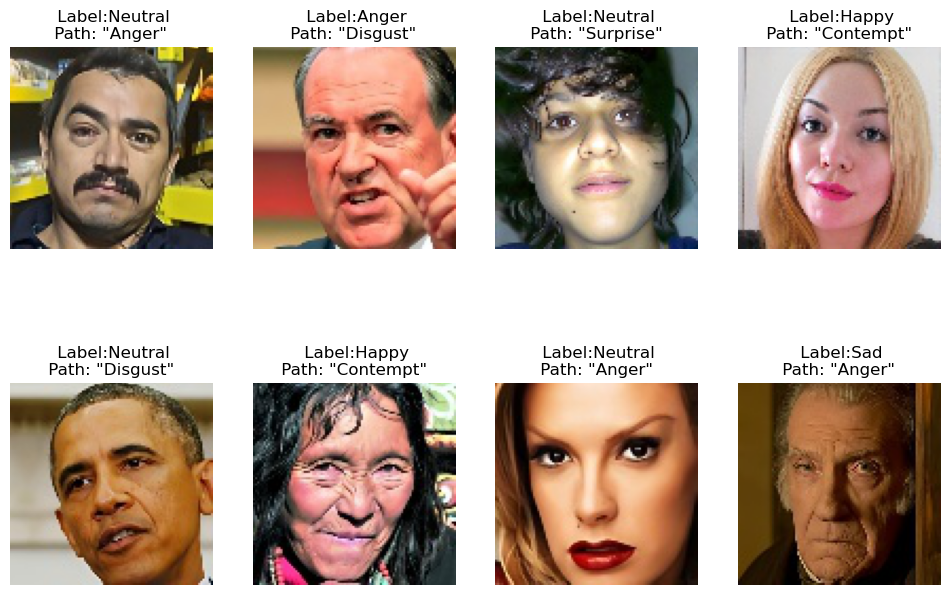

In [26]:
#Visualizations of the images with the conflicted path and label

# Display 8 random images from the dataset
i = 8
random_images = [(randint(1, mismatch_df.shape[0])) for x in range(i)]
num_cols = int(i / 2)
num_rows = int(i / num_cols) + i % 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
for i in range(0, i):
    row = i // num_cols
    col = i % num_cols
    img_path, title, path = render_image(random_images[i],mismatch_df)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f" Label:{title}\n Path: \"{path.split('/')[0].title()}\" ")
    axes[row, col].axis("off")

This will be addressed later, in the section [Adressing Label Mismatch](#adressing-label-mismatch), once the face dataset has been cleaned.


## Removing Faces Oriented Sideways

### Model Test

In [27]:
#MTCNN has a parameter called min_face_size where if it is lower it can detect faces that it wasnt able to detect
#by default at the cost of the accuracy of the points
detector = MTCNN(min_face_size = 30) # Model Used (https://github.com/ipazc/mtcnn)

In [28]:
"""
Function that marks faces based on an array containing the output values of MTCNN to draw a box and mark the points
the faces (for display)
Input: cv2 object, faces array 
Output: image with marks
"""
def mark_faces(cv2_image, faces):
    if len(faces) <= 0:
        return cv2_image #sentinel value
    for face in faces:
        box = face['box']
        conf = face['confidence']
        print("confidence: ", conf)
        x, y, w, h = box[0], box[1], box[2], box[3]
        color = (0, 0,255)
            
        cv2.putText(cv2_image, str(round(conf,2)), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness=1)
        cv2.rectangle(cv2_image, (x, y), (x+w, y+h) , color, 1)

        cv2.circle(cv2_image, face['keypoints']['nose'], 1, color, -1)
        cv2.circle(cv2_image, face['keypoints']['left_eye'], 1, color, -1)
        cv2.circle(cv2_image, face['keypoints']['right_eye'], 1, color, -1)
    
    return cv2_image
"""
Function that calculates the distances of:
- right eye to left eye
- left eye to nose
- right eye to nose
- average distance of righy eye and left eye to the nose
based on the locations indicated in a entry in the faces array and returns the orientation of the head in the image

Input: faces array
Output: String dictating the orientation ("FRONT", "SIDEWAYS", "UPWARDS", "-1") and -1 as the sentinel value
if there are no faces 
detected.

"""
def get_distances(faces):
    if len(faces) <= 0:
        return "NONE"
    for face in faces:
        distance_reye_nose = math.dist(face['keypoints']['right_eye'], face['keypoints']['nose'])
        distance_leye_nose = math.dist(face['keypoints']['left_eye'], face['keypoints']['nose'])
        distance_leye_reye = math.dist(face['keypoints']['left_eye'], face['keypoints']['right_eye'])
        average_distance_eyes_nose = statistics.mean([distance_leye_nose,distance_reye_nose])

        #Checking and removing images if the subject is looking sideways or upwards by calculating face distance.
        if abs(distance_leye_nose - distance_reye_nose) > 5: #threshold value, derived from pure intuition
            return "SIDEWAYS"
        elif average_distance_eyes_nose < 15: #threshold value yet again
            return "UPWARDS"
        else:
           return "FRONT"

1/1 [==============================] - 0s 105ms/step
confidence:  0.9708724617958069
FRONT
1/1 [==============================] - 0s 19ms/step
confidence:  0.9976978898048401
SIDEWAYS
1/1 [==============================] - 0s 19ms/step
confidence:  0.9886873960494995
FRONT
1/1 [==============================] - 0s 18ms/step
confidence:  0.9571421146392822
FRONT
1/1 [==============================] - 0s 18ms/step
confidence:  0.9952002763748169
FRONT


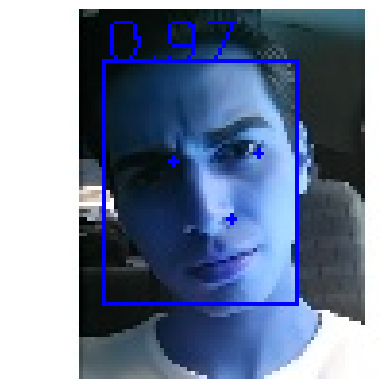

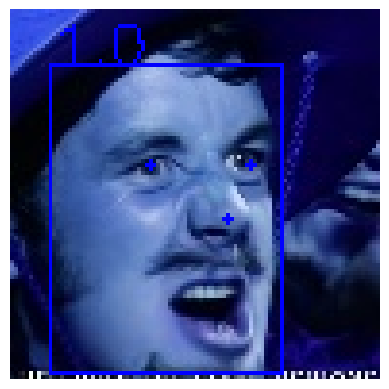

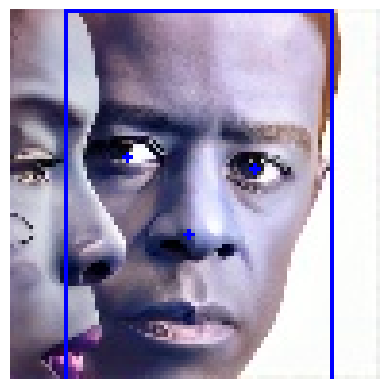

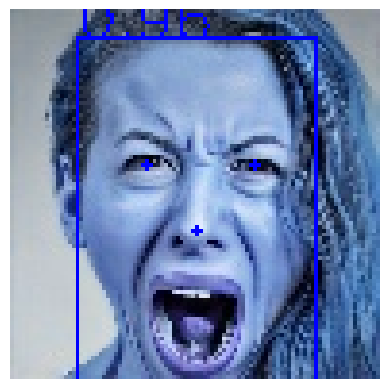

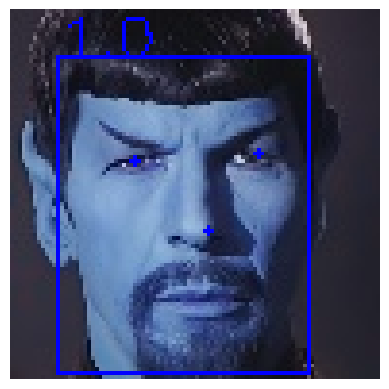

In [29]:
#Check accuracy of the model and calculations

i = 0

#Generate a random sample of images from the DataFrame
#faces_df = faces_df.sample(frac=1)

#Iterate through the DataFrame 
for idx, row in faces_df.iterrows():
    face_img = cv2.imread(base_path + row['pth'])
    faces = detector.detect_faces(face_img)

    face_img = mark_faces(face_img, faces)
    print(get_distances(faces))
    plt.figure()
    plt.imshow(face_img)
    plt.axis('off')
    #print(f"degree: {degree}")
    i+=1
    if i == 5:
        break
    

### Removal Process
Note: This is a very slow process, go to `Optional: Importing dataset without faces oriented sideways` if you would rather re-import the cleaned dataset from the provided csv file.\
Average time to run: `1.5 hours`

In [ ]:
#Removing images flagged as not "front"
#adds a column to the dataframe to indicate if a face is detected, will be useful later for detecting outliers
faces_df['faceDetected'] = True
faces_df['numFaces'] = 0

prev_size = faces_df.shape[0]
for idx, row in faces_df.iterrows():
    face_img = cv2.imread(base_path + row['pth'])
    faces = detector.detect_faces(face_img)
    
    faces_df.at[idx, 'numFaces'] = len(faces)

    #Check if not front and none (checking of none will be done manually)
    if get_distances(faces) != "FRONT" and get_distances(faces) != "NONE":
        faces_df.drop(index=idx, inplace=True)
    
    #If no face detected, set faceDetected to False
    if len(faces) <= 0:
        faces_df.at[idx, 'faceDetected'] = False
    

print(f"{prev_size} => {faces_df.shape[0]}")



Due to the amount of time it takes to perform the process above, the resulting dataframe is saved to `cleaned_faces.csv`. This can then be used to open the result without having to run the data cleaning process again, saving time.

In [17]:
faces_df.to_csv('cleaned_faces.csv', index=False, header=True, encoding='utf-8')

In [23]:
#group by label
sum_df = faces_df[['pth', 'label']].groupby(['label']).count()
sum_df

,pth
label,
anger,3608
contempt,3244
disgust,3472
fear,3043
happy,4336
neutral,2861
sad,2995
surprise,4616


<a id="import-csv"></a>

### Optional: Importing dataset without faces oriented sideways

This code block can be used to import the cleaned dataset after running the process of removing faces oriented sideways.

In [2]:
cleaned_faces_df = pd.read_csv('cleaned_faces.csv')
cleaned_faces_df

,Unnamed: 0,pth,label,relFCs,faceDetected,numFaces
0,1,anger/image0000060.jpg,anger,0.852311,True,1
1,4,anger/image0000106.jpg,anger,0.849108,True,1
2,5,anger/image0000132.jpg,anger,0.819448,True,1
3,6,anger/image0000138.jpg,anger,0.852052,True,1
4,8,anger/image0000195.jpg,anger,0.823133,True,1
...,...,...,...,...,...,...
9845,28135,surprise/image0034829.jpg,happy,0.807797,True,1
9846,28136,surprise/image0034831.jpg,neutral,0.839804,True,1
9847,28164,surprise/image0034931.jpg,happy,0.872834,True,1
9848,28165,surprise/image0034939.jpg,neutral,0.882535,True,1


## Removing multiple faces

Since the model was set to detect all faces in an image, there are instances where multiple faces are detected. To ensure that the model is trained properly, we will remove these images from the dataset.

In [28]:
#Check if there is a row that numFaces > 1
cleaned_faces_df[cleaned_faces_df['numFaces'] > 1]
print("Before: ", cleaned_faces_df.shape[0])

for idx, row in cleaned_faces_df.iterrows():
    if row['numFaces'] > 1:
        cleaned_faces_df.drop(index=idx, inplace=True)
        

print("After: ", cleaned_faces_df.shape[0])


Before:  9850
After:  9844


## Removal of images without faces detected

There are some images wherein the model was also unable to detect a face, this may be due to obstruction or the image showing an incomplete face. We will also remove these images from the dataset.

In [29]:
no_face_df = cleaned_faces_df.loc[cleaned_faces_df['faceDetected'] == False]
print(f"Images with no face detected: {no_face_df.shape[0]}")
print(f"Before: {cleaned_faces_df.shape[0]}")
cleaned_faces_df = cleaned_faces_df.loc[cleaned_faces_df['faceDetected'] == True]
print(f"After: {cleaned_faces_df.shape[0]}")


Images with no face detected: 738
Before: 9844
After: 9106


# Data Modeling

## Extracting Facial Landmarks

After the dataset has been processed, it is now possible to extract the facial landmarks that will be used by a machine learning model for the prediction of the given emotion labels.

### Model Used: [Mediapipe Facial Landmark Detection Model](https://developers.google.com/mediapipe/solutions/vision/face_landmarker)
The Mediapipe Face Landmarker uses machine learning models to create a face mesh that outputs an estimate of 478 3-dimensional face landmarks. The large amount of facial landmarks generated by this model serve as rich representations of the facial expressions. It is able to capture the key points and positions of each part of the face, such as the eyebrows, eyes, nose, and mouth, and even the small details such as the forehead, cheeks, and jaw, allowing the model to provide a comprehensive analysis of facial expressions.

## Facial Landmark Model Testing

Before extracting the facial landmarks of every face in the dataset, the model was first tested on an image not part of the database.

In [4]:
#visualization utilities retrieved from mediapipe documentation:
#https://github.com/googlesamples/mediapipe/blob/main/examples/face_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Face_Landmarker.ipynb

def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

FaceLandmarkerResult(face_landmarks=[[NormalizedLandmark(x=0.5743138790130615, y=0.6889077425003052, z=-0.0757405161857605, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5861771702766418, y=0.6081040501594543, z=-0.11635051667690277, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5806379318237305, y=0.6360802054405212, z=-0.06825906038284302, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5728011727333069, y=0.5384976863861084, z=-0.07820826768875122, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5886233448982239, y=0.5850725769996643, z=-0.12065678834915161, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5904492139816284, y=0.5581714510917664, z=-0.10794224590063095, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.5934493541717529, y=0.49504899978637695, z=-0.0367915965616703, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.43090513348579407, y=0.47988396883010864, z=0.03688709810376167, visibility=0.0, presence=0.0), NormalizedLandmark

(-0.5, 942.5, 942.5, -0.5)

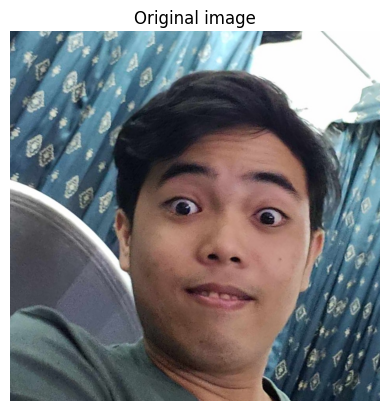

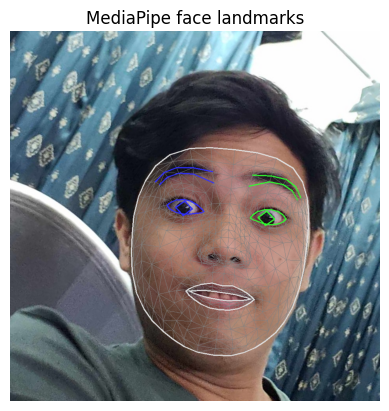

In [5]:
#Model Setup
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)

#Test the model
detector2 = vision.FaceLandmarker.create_from_options(options)               
image = mp.Image.create_from_file("./mediapipe_test.jpg")
detection_result = detector2.detect(image) #this is the line

annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print(detection_result)
#original image
plt.figure()
plt.imshow(image.numpy_view())
plt.title('Original image')
plt.axis('off')
#annotated image
plt.figure()
plt.imshow(annotated_image)
plt.title('MediaPipe face landmarks')
plt.axis('off')

#display the resulting coordinates of each landmark


In [33]:
print("Obtained Landmarks")
print(detection_result.face_landmarks[0][0].x, detection_result.face_landmarks[0][0].y, detection_result.face_landmarks[0][0].z)
print('Count: ', len(detection_result.face_landmarks[0]))

Obtained Landmarks
0.5743138790130615 0.6889077425003052 -0.0757405161857605
Count:  478


## Appending Facial Landmark Values in `cleaned_faces_df`

In [40]:
i = 0
# add a 'landmarks' column to the dataframe
cleaned_faces_df['landmarks'] = None
for idx, row in cleaned_faces_df.iterrows():
    face_img = mp.Image.create_from_file(base_path + row['pth'])
    detection_result = detector2.detect(face_img)
    
    #if no face detected, drop the row
    if len(detection_result.face_landmarks) <= 0:
        cleaned_faces_df.drop(index=idx, inplace=True)
        continue
    #turn it into a list of tuples with the x, y, z coordinates
    cleaned_faces_df.at[idx, 'landmarks'] = [ (landmark.x, landmark.y, landmark.z) for landmark in detection_result.face_landmarks[0] ]
    
    

C:\Users\josha\AppData\Local\Temp\ipykernel_2772\1579304477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df['landmarks'] = None
C:\Users\josha\AppData\Local\Temp\ipykernel_2772\1579304477.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_faces_df.drop(index=idx, inplace=True)
C:\Users\josha\AppData\Local\Temp\ipykernel_2772\1579304477.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [41]:
cleaned_faces_df.to_csv('cleaned_faces_with_landmarks.csv', index=False, header=True, encoding='utf-8')

### Optional: Importing
use the code block below to reimport data of faces with facial landmarks extracted, as long as no changes were performed.

In [2]:
cleaned_faces_df_from_csv = pd.read_csv('cleaned_faces_with_landmarks.csv')
#parse the landmarks column to a list of tuples
cleaned_faces_df_from_csv['landmarks'] = cleaned_faces_df_from_csv['landmarks'].apply(eval)

### Landmark Validation

In [5]:
cleaned_faces_df = cleaned_faces_df_from_csv

<a id="adressing-label-mismatch"></a>

## Addressing label mismatch
As discussed previously, label mismatches were found in the dataset wherein the emotion present in the `label` attribute does not match the emotion presented in the `pth` attribute. To address this, we will duplicate the mismatched rows so that one row will contain the emotion present in the `pth` attribute in the `label` attribute, and the other row will contain the emotion present in the `label` attribute in the `label` attribute.

In [8]:
#Check mismatched labels again after cleaning
mismatch_df = cleaned_faces_df.loc[cleaned_faces_df['pth'].str.split('/').str[0] != cleaned_faces_df['label']]

print(f"Mismatched Path-Label: {mismatch_df.shape[0]}")
print(f"Before: {cleaned_faces_df.shape[0]}")
for idx, row in mismatch_df.iterrows():
    pth_emotion = row['pth'].split('/')[0]

    #find the row in cleaned_faces_df and deep copy
    cleaned_faces_row = cleaned_faces_df.loc[cleaned_faces_df['pth'] == row['pth']].copy(deep=True)
    cleaned_faces_row['label'] = pth_emotion

    #If the row is present, concat the new row with the changed value
    if cleaned_faces_row.shape[0] > 0:
        cleaned_faces_df = pd.concat([cleaned_faces_df, cleaned_faces_row])
        
emotions = ['happy', 'sad', 'anger', 'neutral']
cleaned_faces_df = cleaned_faces_df[cleaned_faces_df['label'].isin(emotions)]
print(f"After: {cleaned_faces_df.shape[0]}")

Mismatched Path-Label: 2758
Before: 17367
After: 19453


In [9]:
#Displays the rows with duplicate paths to prove code above works
cleaned_faces_df[cleaned_faces_df.duplicated(subset='pth', keep=False)].sort_values(by='pth').head(10)

,Unnamed: 0,pth,label,relFCs,faceDetected,numFaces,landmarks
10,23,anger/image0000441.jpg,sad,0.792900,True,1,"[(0.5179503560066223, 0.7008240818977356, -0.1..."
10,23,anger/image0000441.jpg,anger,0.792900,True,1,"[(0.5179503560066223, 0.7008240818977356, -0.1..."
10,23,anger/image0000441.jpg,anger,0.792900,True,1,"[(0.5179503560066223, 0.7008240818977356, -0.1..."
10,23,anger/image0000441.jpg,anger,0.792900,True,1,"[(0.5179503560066223, 0.7008240818977356, -0.1..."
10,23,anger/image0000441.jpg,anger,0.792900,True,1,"[(0.5179503560066223, 0.7008240818977356, -0.1..."
10,23,anger/image0000441.jpg,anger,0.792900,True,1,"[(0.5179503560066223, 0.7008240818977356, -0.1..."
10,23,anger/image0000441.jpg,anger,0.792900,True,1,"[(0.5179503560066223, 0.7008240818977356, -0.1..."
10,23,anger/image0000441.jpg,anger,0.792900,True,1,"[(0.5179503560066223, 0.7008240818977356, -0.1..."
15,30,anger/image0000690.jpg,anger,0.853798,True,1,"[(0.5111130475997925, 0.7222180962562561, -0.0..."
15,30,anger/image0000690.jpg,anger,0.853798,True,1,"[(0.5111130475997925, 0.7222180962562561, -0.0..."


## Oversampling
This will be used to oversample images according to the highest amount of images in an emotion label. This is needed so that during the training portion of the emotion recognition model, it's emotion recognition functionality may not be skewed favoring one emotion.

In [10]:
dict_df_emotions = {
    "happy" :  cleaned_faces_df[cleaned_faces_df['label'] == 'happy'],
    "sad" : cleaned_faces_df[cleaned_faces_df['label'] == 'sad'],
    "anger" : cleaned_faces_df[cleaned_faces_df['label'] == 'anger'],
    "neutral" : cleaned_faces_df[cleaned_faces_df['label'] == 'neutral']
}

dict_counts = {
    "happy" : dict_df_emotions['happy'].shape[0],
    "sad" : dict_df_emotions['sad'].shape[0],
    "anger" : dict_df_emotions['anger'].shape[0],
    "neutral" : dict_df_emotions['neutral'].shape[0]
}

dict_counts = dict(sorted(dict_counts.items(), key = lambda item : item[1],  reverse = True))
dict_counts

{'neutral': 7253, 'sad': 4452, 'happy': 3952, 'anger': 3796}

In [11]:
#Step 3: Get number of oversampled images needed for each emotion
highest_count = dict_counts[list(dict_counts)[0]]

print(highest_count)

oversampling_count = {
    "happy" : highest_count - dict_df_emotions['happy'].shape[0],
    "sad" : highest_count - dict_df_emotions['sad'].shape[0],
    "anger" : highest_count - dict_df_emotions['anger'].shape[0],
    "neutral" : highest_count - dict_df_emotions['neutral'].shape[0]
}

oversampling_count

7253


{'happy': 3301, 'sad': 2801, 'anger': 3457, 'neutral': 0}

In [12]:
#Step 4: for each emotion, generate new images according to oversampling count

for emotion in list(oversampling_count):
    print("=======!!!", emotion, oversampling_count[emotion],"!!!=======")
    max_range = dict_df_emotions[emotion].shape[0] - 1
    added_rows_df = pd.DataFrame()
    emotion_indices = []
    print(dict_df_emotions[emotion])
    print("====== INDEX:", max_range,"======")
    print(dict_df_emotions[emotion].iloc[max_range])
    for i in range(oversampling_count[emotion]):
        #Pick a random entry inside of the given emotion
        random_index = randint(0, max_range)
        
        emotion_indices.append(random_index)
    
    added_rows_df = pd.concat([added_rows_df, dict_df_emotions[emotion].iloc[emotion_indices]])
    
    print("Count:", added_rows_df.shape[0])
    
    dict_df_emotions[emotion] = pd.concat([dict_df_emotions[emotion], added_rows_df])
    
    print("New Count:", dict_df_emotions[emotion].shape[0])
    
    added_rows_df.drop(added_rows_df.index , inplace=True)

=======!!! happy 3301 !!!=======
      Unnamed: 0                     pth  label    relFCs  faceDetected  \
47            93  anger/image0001956.jpg  happy  0.877426          True   
117          235  anger/image0004504.jpg  happy  0.785613          True   
171          332  anger/image0006510.jpg  happy  0.721998          True   
254          487  anger/image0009562.jpg  happy  0.728166          True   
346          679  anger/image0012970.jpg  happy  0.862007          True   
...          ...                     ...    ...       ...           ...   
5541       16155  happy/image0030780.jpg  happy  0.678524          True   
5543       16168  happy/image0032290.jpg  happy  0.795762          True   
5543       16168  happy/image0032290.jpg  happy  0.795762          True   
5543       16168  happy/image0032290.jpg  happy  0.795762          True   
5543       16168  happy/image0032290.jpg  happy  0.795762          True   

      numFaces                                          landmarks 

In [13]:
#Last step: merge all emotions back
dfs = [dict_df_emotions['happy'], dict_df_emotions['sad'], dict_df_emotions['anger'], dict_df_emotions['neutral']]
new_faces_df = pd.concat(dfs)
new_faces_df

#remove "Unnamed: 0" column and reset index
new_faces_df = new_faces_df.drop(columns=['Unnamed: 0'])
new_faces_df.reset_index(drop=True, inplace=True)

<function matplotlib.pyplot.show(close=None, block=None)>

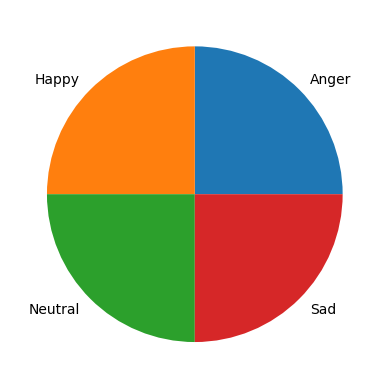

In [14]:
sum_df = new_faces_df[['pth', 'label']].groupby(['label']).count()
sum_df.rename(columns={'pth':'sum'}, inplace=True)
plt.pie(sum_df['sum'], labels = ['Anger', 'Happy', 'Neutral', 'Sad'])
plt.show

# Machine Learning Dataframe
After the cleaning, pre-processing, and feature extraction of the dataset, we will now create a separate dataset that only contains the necessary data for training the model.

In [15]:
model_training_df = new_faces_df[['label','landmarks']]
model_training_df.reset_index(inplace=True)
model_training_df

,index,label,landmarks
0,0,happy,"[(0.5075767636299133, 0.6905035972595215, -0.0..."
1,1,happy,"[(0.506913423538208, 0.6853656768798828, -0.05..."
2,2,happy,"[(0.5290422439575195, 0.6751238107681274, -0.0..."
3,3,happy,"[(0.5999926328659058, 0.7471040487289429, -0.0..."
4,4,happy,"[(0.4938056170940399, 0.7192921042442322, -0.0..."
...,...,...,...
29007,29007,neutral,"[(0.5139895677566528, 0.7702787518501282, -0.0..."
29008,29008,neutral,"[(0.5242704749107361, 0.708551287651062, -0.07..."
29009,29009,neutral,"[(0.5242704749107361, 0.708551287651062, -0.07..."
29010,29010,neutral,"[(0.5242704749107361, 0.708551287651062, -0.07..."


In [16]:
# Extract x, y, and z coordinates from the tuples in the 'landmarks' column
coordinates = model_training_df['landmarks'].apply(lambda x: [coord for landmark in x for coord in landmark])

# Create a DataFrame from the extracted coordinates
landmarks_df = pd.DataFrame(coordinates.tolist(), columns=[f'landmark_{i+1}_{coord}' for i in range(len(coordinates.iloc[0]) // 3) for coord in ['x', 'y', 'z']])

# Concatenate the original DataFrame with the new landmarks DataFrame
model_training_df = pd.concat([model_training_df, landmarks_df], axis=1)

# Drop the original 'landmarks' column
model_training_df.drop(columns=['landmarks'], inplace=True)



In [17]:
model_training_df

,index,label,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,landmark_3_y,...,landmark_475_z,landmark_476_x,landmark_476_y,landmark_476_z,landmark_477_x,landmark_477_y,landmark_477_z,landmark_478_x,landmark_478_y,landmark_478_z
0,0,happy,0.507577,0.690504,-0.067539,0.496229,0.623151,-0.169093,0.502712,0.643993,...,-0.007745,0.644046,0.382131,-0.007746,0.616720,0.409790,-0.007778,0.648537,0.432745,-0.007774
1,1,happy,0.506913,0.685366,-0.056324,0.531459,0.619465,-0.139276,0.513914,0.632298,...,0.030370,0.604874,0.417298,0.030375,0.580915,0.438486,0.030342,0.605856,0.459424,0.030347
2,2,happy,0.529042,0.675124,-0.048689,0.521464,0.605306,-0.131408,0.522370,0.623367,...,0.001254,0.629228,0.374716,0.001255,0.608027,0.400481,0.001223,0.634681,0.421634,0.001229
3,3,happy,0.599993,0.747104,-0.070677,0.613960,0.620251,-0.156688,0.594227,0.654728,...,0.073009,0.664438,0.387820,0.073013,0.648348,0.409021,0.072974,0.671501,0.424706,0.072984
4,4,happy,0.493806,0.719292,-0.075153,0.504832,0.598530,-0.145169,0.502998,0.630493,...,0.028723,0.658979,0.422724,0.028730,0.630458,0.440460,0.028699,0.653501,0.464135,0.028702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29007,29007,neutral,0.513990,0.770279,-0.061498,0.512767,0.652325,-0.164406,0.511889,0.680238,...,-0.006817,0.666343,0.389803,-0.006814,0.636263,0.416423,-0.006850,0.667566,0.441180,-0.006846
29008,29008,neutral,0.524270,0.708551,-0.071542,0.509271,0.603736,-0.149742,0.514356,0.632137,...,0.013836,0.642027,0.366623,0.013838,0.614825,0.393726,0.013800,0.644252,0.418167,0.013807
29009,29009,neutral,0.524270,0.708551,-0.071542,0.509271,0.603736,-0.149742,0.514356,0.632137,...,0.013836,0.642027,0.366623,0.013838,0.614825,0.393726,0.013800,0.644252,0.418167,0.013807
29010,29010,neutral,0.524270,0.708551,-0.071542,0.509271,0.603736,-0.149742,0.514356,0.632137,...,0.013836,0.642027,0.366623,0.013838,0.614825,0.393726,0.013800,0.644252,0.418167,0.013807


In [19]:
# Export to CSV (if RapidMiner will be used)
model_training_df.to_csv('model_training_data.csv', index=True, header=True, encoding='utf-8')

## Model Setup, Training, and Evaluation

*To be followed*\
Plans:\
1 for normal model\
1 with faces split\
1 for a modified dataset with occluded body parts